# Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('fivethirtyeight')

In [2]:
!pip install opendatasets --upgrade --quiet

In [3]:
import opendatasets as od

url = 'https://www.kaggle.com/datasets/camnugent/california-housing-prices'
od.download(url)

100%|██████████| 400k/400k [00:00<00:00, 50.8MB/s]

In [4]:
data_set = pd.read_csv('./california-housing-prices/housing.csv')
data_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


# Data preparation

### Fill the missing values with 0.

In [5]:
data_set.isna().sum().sum()

207

In [6]:
data_set.fillna(0, inplace=True)

In [7]:
data_set.isna().sum().sum()

0

### Create columns:
- `rooms_per_household `
- `bedrooms_per_room`
- `population_per_household`

In [8]:
data_set = (
    data_set.assign(
        rooms_per_household = data_set.total_rooms / data_set.households,
        bedrooms_per_room = data_set.total_bedrooms / data_set.total_rooms,
        population_per_household = data_set.population / data_set.households,
    )
)

In [9]:
data_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,rooms_per_household,bedrooms_per_room,population_per_household
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,6.984127,0.146591,2.555556
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,6.238137,0.155797,2.109842
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,8.288136,0.129516,2.802260
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,5.817352,0.184458,2.547945
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,6.281853,0.172096,2.181467


# Question 1
What is the most frequent observation (mode) for the column `ocean_proximity`?

In [10]:
data_set['ocean_proximity'].describe(include='object')

count         20640
unique            5
top       <1H OCEAN
freq           9136
Name: ocean_proximity, dtype: object

`<1H OCEAN`

## Split the data

In [11]:
from sklearn.model_selection import train_test_split

X_total, y_total = data_set.drop(columns=['median_house_value']), data_set['median_house_value']

X, X_test, y, y_test = train_test_split(X_total, y_total, test_size = 0.2, random_state=42)
dev_size = X_test.shape[0] / X.shape[0]
X_train, X_dev, y_train, y_dev = train_test_split(X, y,
                                                      test_size = dev_size,
                                                      random_state=42)

X_train.shape, y_train.shape, X_dev.shape, y_dev.shape, X_test.shape, y_test.shape

((12384, 12), (12384,), (4128, 12), (4128,), (4128, 12), (4128,))

# Question 2
- Create the correlation matrix for the numerical features of your train dataset. 

In [12]:
from sklearn.compose import make_column_selector as selector

numerical = selector(dtype_exclude=object)(X_total)
categorical = selector(dtype_include=object)(X_total)

In [13]:
numerical

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'rooms_per_household',
 'bedrooms_per_room',
 'population_per_household']

In [14]:
categorical

['ocean_proximity']

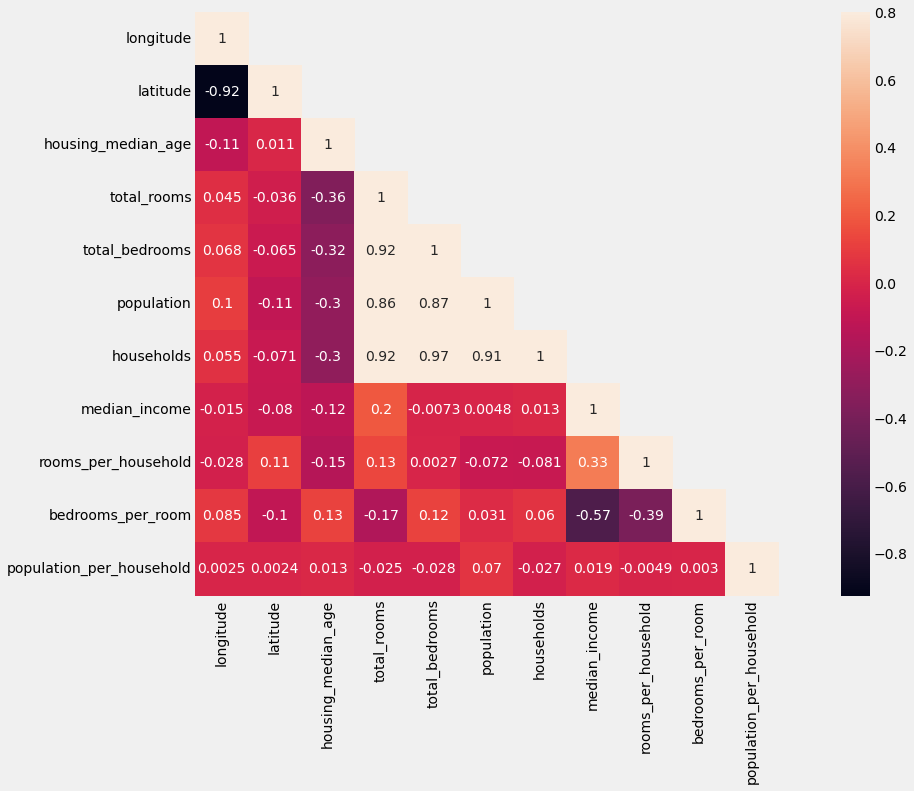

In [15]:
corr_mat = X_total[numerical].corr()
mask = np.array(corr_mat)
mask[np.tril_indices_from(mask)] = False
fig,ax= plt.subplots()
fig.set_size_inches(20,10)

sns.heatmap(corr_mat, mask=mask,vmax=.8, square=True,annot=True);


- What are the two features that have the biggest correlation in this dataset?

total_bedrooms and households $R = 0.97$

# Make median_house_value binary

- We need to turn the `median_house_value` variable from numeric into binary.
- Let's create a variable `above_average` which is 1 if the `median_house_value` is above its mean value and 0 otherwise.


In [16]:
above_average = y_total.apply(lambda x: x >= y_total.mean()).map({True: 1, False: 0})

In [17]:
y_train_copied = y_train.copy()
y_dev_copied = y_dev.copy()
y_test_copied = y_test.copy()

In [18]:
y_train = y_train.apply(lambda x: x >= y_total.mean()).map({True: 1, False: 0})
y_dev = y_dev.apply(lambda x: x >= y_total.mean()).map({True: 1, False: 0})
y_test = y_test.apply(lambda x: x >= y_total.mean()).map({True: 1, False: 0})

In [19]:
y_train.head()

17244    1
8817     1
19686    0
3545     1
17019    1
Name: median_house_value, dtype: int64

# Question 3
- Calculate the mutual information score with the (binarized) price for the categorical variable that we have. Use the training set only.


In [20]:
from sklearn.metrics import mutual_info_score

mi = mutual_info_score(X_train['ocean_proximity'], y_train).round(2)
mi

0.1

# Question 4

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer


dv = DictVectorizer(sparse = False)

train_dico = X_train[categorical + numerical].to_dict(orient= 'records')
x_tr = dv.fit_transform(train_dico)

val_dico = X_dev[categorical + numerical].to_dict(orient = 'records')
x_dv = dv.transform(val_dico)

In [22]:
model = LogisticRegression(solver="liblinear", C=1.0, max_iter=1000, random_state=42)
model.fit(x_tr, y_train)

LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')

In [23]:
y_pred = model.predict_proba(x_dv)[:, 1]
y_pred

array([0.08070483, 0.16658343, 0.9521661 , ..., 0.96101702, 0.85154537,
       0.46412263])

- Calculate the accuracy on the validation dataset 

In [24]:
above_average_decision = (y_pred >= 0.5)
above_average_decision

array([False, False,  True, ...,  True,  True, False])

In [25]:
accuracy = (y_dev == above_average_decision).mean()

In [26]:
accuracy.round(2)

0.84

# Question 5
feature elimination

In [27]:
def feature_elimination(accuracy):
  features = categorical + numerical
  acc_diff = {}
  dv = DictVectorizer(sparse = False)

  for f in features:
      features_copy = features.copy()
      features_copy.remove(f)
      train_dico = X_train[features_copy].to_dict(orient= 'records')
      x_tr = dv.fit_transform(train_dico)
      
      val_dico = X_dev[features_copy].to_dict(orient = 'records')
      x_dv = dv.transform(val_dico)

      model = LogisticRegression(solver="liblinear", C=1.0, max_iter=1000, random_state=42)
      model.fit(x_tr, y_train)

      y_pred = model.predict_proba(x_dv)[:, 1]
      above_average_decision = (y_pred >= 0.5)

      acc = (y_dev == above_average_decision).mean()

      diff = abs(acc - accuracy)
      acc_diff[f] = diff

  return acc_diff

In [28]:
acc_diff = feature_elimination(accuracy=accuracy)

In [29]:
acc_diff

{'ocean_proximity': 0.014534883720930258,
 'longitude': 0.004602713178294526,
 'latitude': 0.0016957364341084746,
 'housing_median_age': 0.004602713178294526,
 'total_rooms': 0.0029069767441860517,
 'total_bedrooms': 0.0021802325581395943,
 'population': 0.009205426356589164,
 'households': 0.0021802325581394832,
 'median_income': 0.049903100775193776,
 'rooms_per_household': 0.001211240310077466,
 'bedrooms_per_room': 0.0,
 'population_per_household': 0.0}

- Feature with the smallest difference

In [30]:
min(acc_diff, key=acc_diff.get)

'bedrooms_per_room'

Which of following feature has the smallest difference?

- total_rooms
- total_bedrooms
- population
- households


In [31]:
acc_filtred = { f: acc_diff[f] for f in ['total_rooms', 'total_bedrooms', 'population', 'households'] }
min(acc_filtred, key=acc_filtred.get)

'households'

# Question 6

- Apply the logarithmic transformation to `median_house_value`

In [32]:
y_train = np.log1p(y_train_copied)
y_dev = np.log1p(y_dev_copied)

In [33]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

def best_rmse():
  a = [0, 0.01, 0.1, 1, 10]
  err = []
  for i in a:
    model = Ridge(alpha=i, solver="sag", random_state=42)
    model.fit(x_tr, y_train)
    y_pred = model.predict(x_dv)
    error = round(mean_squared_error(y_dev, y_pred, squared=False), 3)
    err.append(error)

  return a, err, sorted(list(zip(a, err)), key=lambda x : x[-1])

<function matplotlib.pyplot.show(*args, **kw)>

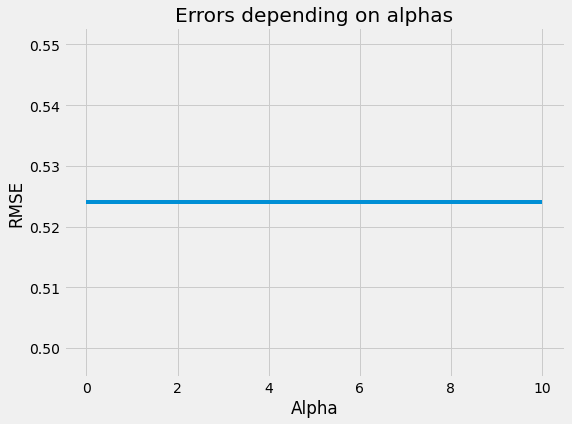

In [34]:
a, err, rmse = best_rmse()

plt.figure(figsize=(8, 6))
plt.plot(a, err)
plt.xlabel('Alpha')
plt.ylabel('RMSE')
plt.title('Errors depending on alphas')
plt.show

In [35]:
rmse

[(0, 0.524), (0.01, 0.524), (0.1, 0.524), (1, 0.524), (10, 0.524)]